**Simple Neural Network**


In this lab we will build a small neural network using Tensorflow.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
import matplotlib.colors as colors
from tensorflow.keras.activations import sigmoid
from matplotlib import cm

In [2]:
def load_coffee_data():
    """ Creates a coffee roasting data set.
        roasting duration: 12-15 minutes is best
        temperature range: 175-260C is best
    """
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1,2)
    X[:,1] = X[:,1] * 4 + 11.5          # 12-15 min is best
    X[:,0] = X[:,0] * (285-150) + 150  # 350-500 F (175-260 C) is best
    Y = np.zeros(len(X))
    
    i=0
    for t,d in X:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (X, Y.reshape(-1,1))

**DataSet**

In [3]:
X,Y = load_coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


In [4]:
dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0', dldarkblue =  '#0D5BDC')
def plt_roast(X,Y):
    Y = Y.reshape(-1,)
    colormap = np.array(['r', 'b'])
    fig, ax = plt.subplots(1,1,)
    ax.scatter(X[Y==1,0],X[Y==1,1], s=70, marker='x', c='red', label="Good Roast" )
    ax.scatter(X[Y==0,0],X[Y==0,1], s=100, marker='o', facecolors='none', 
               edgecolors=dlc["dldarkblue"],linewidth=1,  label="Bad Roast")
    tr = np.linspace(175,260,50)
    ax.plot(tr, (-3/85) * tr + 21, color=dlc["dlpurple"],linewidth=1)
    ax.axhline(y=12,color=dlc["dlpurple"],linewidth=1)
    ax.axvline(x=175,color=dlc["dlpurple"],linewidth=1)
    ax.set_title(f"Coffee Roasting", size=16)
    ax.set_xlabel("Temperature \n(Celsius)",size=12)
    ax.set_ylabel("Duration \n(minutes)",size=12)
    ax.legend(loc='upper right')
    plt.show()

Let's plot the coffee roasting data below. The two features are Temperature in Celsius and Duration in minutes. [Coffee Roasting at Home](https://www.merchantsofgreencoffee.com/how-to-roast-green-coffee-in-your-oven/) suggests that the duration is best kept between 12 and 15 minutes while the temp should be between 175 and 260 degrees Celsius. Of course, as temperature rises, the duration should shrink. 

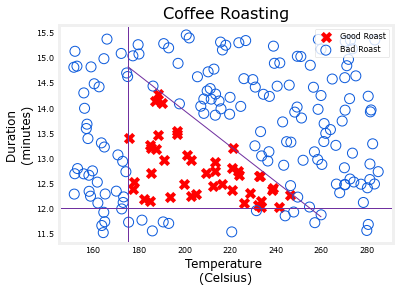

In [5]:
plt_roast(X,Y)

**Normalize Data**
Fitting the weights to the dadta will proceed more quickly if the data is normalized. The procedure below uses a Keras [normalization layer](https://keras.io/api/layers/preprocessing_layers/numerical/normalization/)

* Create a "Normalization Layer". Note, as applied here, this is not a layer in your model. 
* 'adapt' the data. This learns the mean and variance of the data set and saves that values internally.
* Normalize data.

It is important to apply normalization to any future data that utilizes the learned model.

In [6]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
norm_l = tf.keras.layers.Normalization(axis=1)
norm_l.adapt(X) # learns mean, variance
Xn = norm_l(X)
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")


Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


Tile/copy our data to increase the training set size and reduce the number of training epochs.

In [7]:
Xt = np.tile(Xn, (1000,1))
Yt = np.tile(Y, (1000,1))
print(Xt.shape, Yt.shape)

(200000, 2) (200000, 1)


**Model**
   <center> <img  src="C2_W1_RoastingNetwork.PNG" width="200" />   <center/>  
Let's build the "Coffee Roasting Network" described in lecture. There are two layers with sigmoid activations as shown below:

In [8]:
tf.random.set_seed(1234) #applied to achieve consisstent results
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation = 'sigmoid', name = 'layer1'),
        Dense(1, activation = 'sigmoid', name = 'layer2')
    ]
)

>**Note 1:** The `tf.keras.Input(shape=(2,)),` specifies the expected shape of the input. This allows Tensorflow to size the weights and bias parameters at this point.  This is useful when exploring Tensorflow models. This statement can be omitted in practice and Tensorflow will size the network parameters when the input data is specified in the `model.fit` statement.  
>**Note 2:** Including the sigmoid activation in the final layer is not considered best practice. It would instead be accounted for in the loss which improves numerical stability. This will be described in more detail in a later lab.

The `model.summary()` provides a description of the network:

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 3)                 9         
_________________________________________________________________
layer2 (Dense)               (None, 1)                 4         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


The parameter counts shown in the summary correspond to the number of elements in the weight and bias arrays as shown below.

In [21]:
L1_num_params = 2 * 3 + 3   # W1 parameters  + b1 parameters
L2_num_params = 3 * 1 + 1   # W2 parameters  + b2 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params  )

L1 params =  9 , L2 params =  4


Let's examine the weights and biases Tensorflow has instantiated.  The weights $W$ should be of size (number of features in input, number of units in the layer) while the bias $b$ size should match the number of units in the layer:
- In the first layer with 3 units, we expect W to have a size of (2,3) and $b$ should have 3 elements.
- In the second layer with 1 unit, we expect W to have a size of (3,1) and $b$ should have 1 element.

In [12]:
W1, b1 = model.get_layer('layer1').get_weights()
W2, b2 = model.get_layer('layer2').get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[ 0.08334005 -0.29660565  0.17884266]
 [-0.56124383 -0.15262699  0.8899205 ]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[-0.4277674 ]
 [-0.88499916]
 [ 0.3626454 ]] 
b2(1,): [0.]


- The `model.compile` statement defines a loss function and specifies a compile optimization.
- The `model.fit` statement runs gradient descent and fits the weights to the data.

In [13]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    Xt,Yt,            
    epochs=10,
)

Epoch 1/10
6250/6250 [==============================] - 6s 895us/step - loss: 0.1782
Epoch 2/10
6250/6250 [==============================] - 5s 779us/step - loss: 0.1165
Epoch 3/10
6250/6250 [==============================] - 5s 815us/step - loss: 0.0426
Epoch 4/10
6250/6250 [==============================] - 5s 804us/step - loss: 0.0160
Epoch 5/10
6250/6250 [==============================] - 5s 807us/step - loss: 0.0104
Epoch 6/10
6250/6250 [==============================] - 5s 840us/step - loss: 0.0073
Epoch 7/10
6250/6250 [==============================] - 5s 805us/step - loss: 0.0052
Epoch 8/10
6250/6250 [==============================] - 5s 807us/step - loss: 0.0037
Epoch 9/10
6250/6250 [==============================] - 5s 795us/step - loss: 0.0027
Epoch 10/10
6250/6250 [==============================] - 5s 788us/step - loss: 0.0020


***Updated Weights***


After fitting, the weights have been updated: 

In [14]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[ -0.12673342  14.295985   -11.096141  ]
 [ -8.91638     11.853637    -0.25223953]] 
b1: [-11.162896    1.7599382 -12.097769 ]
W2:
 [[-45.71033]
 [-42.94524]
 [-50.18991]] 
b2: [26.144836]


***Predictions***


Once you have a trained model, you can then use it to make predictions. Recall that the output of our model is a probability. In this case, the probability of a good roast. To make a decision, one must apply the probability to a threshold. In this case, we will use 0.5

Let's start by creating input data. The model is expecting one or more examples where examples are in the rows of matrix. In this case, we have two features so the matrix will be (m,2) where m is the number of examples.
Recall, we have normalized the input features so we must normalize our test data as well.   
To make a prediction, you apply the `predict` method.

In [16]:
X_test = np.array([
    [200, 13.9], # postive example
    [200, 17]    # negative example
])

X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

predictions = 
 [[9.8903829e-01]
 [4.9423033e-08]]


***Epochs and batches***

In the `compile` statement above, the number of `epochs` was set to 10. This specifies that the entire data set should be applied during training 10 times.  During training, you see output describing the progress of training that looks like this:
```
Epoch 1/10
6250/6250 [==============================] - 6s 910us/step - loss: 0.1782
```
The first line, `Epoch 1/10`, describes which epoch the model is currently running. For efficiency, the training data set is broken into 'batches'. The default size of a batch in Tensorflow is 32. There are 200000 examples in our expanded data set or 6250 batches. The notation on the 2nd line `6250/6250 [====` is describing which batch has been executed.

To convert the probabilities to a decision, we apply a threshold:

In [20]:
print(predictions)
print(np.zeros_like(predictions))
print(len(predictions))

[[9.8903829e-01]
 [4.9423033e-08]]
[[0.]
 [0.]]
2


In [22]:
y_hat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        y_hat[i] = 1
    else :
        y_hat[i] = 0
print(f"decisions = \n {y_hat}")

decisions = 
 [[1.]
 [0.]]


This can be accomplished more succinctly:

In [23]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


In [27]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """ truncates color map """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [34]:
def plt_prob(ax,fwb):
    """ plots a decision boundary but include shading to indicate the probability """
    #setup useful ranges and common linspaces
    x0_space  = np.linspace(150, 285 , 40)
    x1_space  = np.linspace(11.5, 15.5 , 40)

    # get probability for x0,x1 ranges
    tmp_x0,tmp_x1 = np.meshgrid(x0_space,x1_space)
    z = np.zeros_like(tmp_x0)
    for i in range(tmp_x0.shape[0]):
        for j in range(tmp_x1.shape[1]):
            x = np.array([[tmp_x0[i,j],tmp_x1[i,j]]])
            z[i,j] = fwb(x)


    cmap = plt.get_cmap('Blues')
    new_cmap = truncate_colormap(cmap, 0.0, 0.5)
    pcm = ax.pcolormesh(tmp_x0, tmp_x1, z,
                   norm=cm.colors.Normalize(vmin=0, vmax=1),
                   cmap=new_cmap, shading='nearest', alpha = 0.9)
    ax.figure.colorbar(pcm, ax=ax)

In [36]:
def plt_layer(X,Y,W1,b1,norm_l):
    Y = Y.reshape(-1,)
    fig,ax = plt.subplots(1,W1.shape[1], figsize=(16,4))
    for i in range(W1.shape[1]):
        layerf= lambda x : sigmoid(np.dot(norm_l(x),W1[:,i]) + b1[i])
        plt_prob(ax[i], layerf)
        ax[i].scatter(X[Y==1,0],X[Y==1,1], s=70, marker='x', c='red', label="Good Roast" )
        ax[i].scatter(X[Y==0,0],X[Y==0,1], s=100, marker='o', facecolors='none', 
                   edgecolors=dlc["dldarkblue"],linewidth=1,  label="Bad Roast")
        tr = np.linspace(175,260,50)
        ax[i].plot(tr, (-3/85) * tr + 21, color=dlc["dlpurple"],linewidth=2)
        ax[i].axhline(y= 12, color=dlc["dlpurple"], linewidth=2)
        ax[i].axvline(x=175, color=dlc["dlpurple"], linewidth=2)
        ax[i].set_title(f"Layer 1, unit {i}")
        ax[i].set_xlabel("Temperature \n(Celsius)",size=12)
    ax[0].set_ylabel("Duration \n(minutes)",size=12)
    plt.show()

**Layer Functions**


Let's examine the functions of the units to determine their role in the coffee roasting decision. We will plot the output of each node for all values of the inputs (duration,temp). Each unit is a logistic function whose output can range from zero to one. The shading in the graph represents the output value.
> Note: In labs we typically number things starting at zero while the lectures may start with 1.

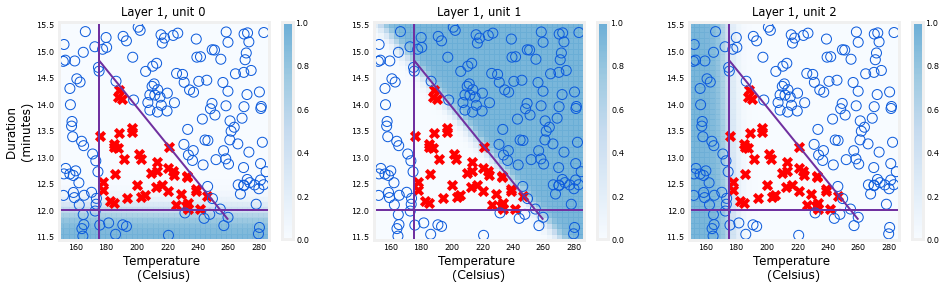

In [37]:
plt_layer(X,Y.reshape(-1,),W1,b1,norm_l)

The shading shows that each unit is responsible for a different "bad roast" region. unit 0 has larger values when the temperature is too low. unit 1 has larger values when the duration is too short and unit 2 has larger values for bad combinations of time/temp. It is worth noting that the network learned these functions on its own through the process of gradient descent. They are very much the same sort of functions a person might choose to make the same decisions.

The final graph shows the whole network in action.  
The left graph is the raw output of the final layer represented by the blue shading. This is overlaid on the training data represented by the X's and O's.   
The right graph is the output of the network after a decision threshold. The X's and O's here correspond to decisions made by the network.  
The following takes a moment to run

In [39]:
def plt_network(X,Y,netf):
    fig, ax = plt.subplots(1,2,figsize=(16,4))
    Y = Y.reshape(-1,)
    plt_prob(ax[0], netf)
    ax[0].scatter(X[Y==1,0],X[Y==1,1], s=70, marker='x', c='red', label="Good Roast" )
    ax[0].scatter(X[Y==0,0],X[Y==0,1], s=100, marker='o', facecolors='none', 
                   edgecolors=dlc["dldarkblue"],linewidth=1,  label="Bad Roast")
    ax[0].plot(X[:,0], (-3/85) * X[:,0] + 21, color=dlc["dlpurple"],linewidth=1)
    ax[0].axhline(y= 12, color=dlc["dlpurple"], linewidth=1)
    ax[0].axvline(x=175, color=dlc["dlpurple"], linewidth=1)
    ax[0].set_xlabel("Temperature \n(Celsius)",size=12)
    ax[0].set_ylabel("Duration \n(minutes)",size=12)
    ax[0].legend(loc='upper right')
    ax[0].set_title(f"network probability")

    ax[1].plot(X[:,0], (-3/85) * X[:,0] + 21, color=dlc["dlpurple"],linewidth=1)
    ax[1].axhline(y= 12, color=dlc["dlpurple"], linewidth=1)
    ax[1].axvline(x=175, color=dlc["dlpurple"], linewidth=1)
    fwb = netf(X)
    yhat = (fwb > 0.5).astype(int)
    ax[1].scatter(X[yhat[:,0]==1,0],X[yhat[:,0]==1,1], s=70, marker='x', c='orange', label="Predicted Good Roast" )
    ax[1].scatter(X[yhat[:,0]==0,0],X[yhat[:,0]==0,1], s=100, marker='o', facecolors='none', 
                   edgecolors=dlc["dldarkblue"],linewidth=1,  label="Bad Roast")
    ax[1].set_title(f"network decision")
    ax[1].set_xlabel("Temperature \n(Celsius)",size=12)
    ax[1].set_ylabel("Duration \n(minutes)",size=12)
    ax[1].legend(loc='upper right')

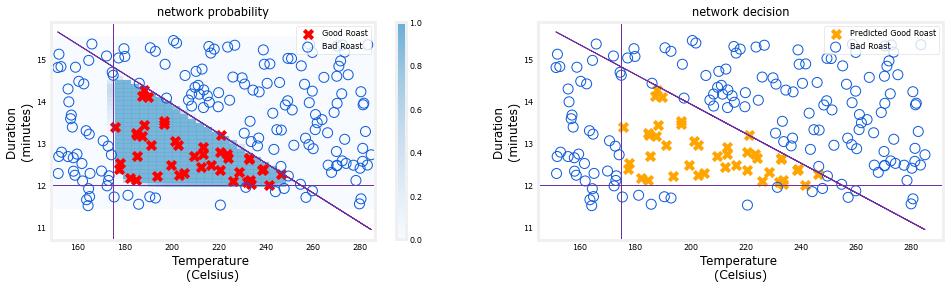

In [40]:
netf= lambda x : model.predict(norm_l(x))
plt_network(X,Y,netf)